In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_source = pd.read_csv("data_Q1_2021/2021-01-15.csv", parse_dates=["date"])
df_source.head()
print(df_source["smart_9_raw"]) # power-on hours
print(df_source["smart_231_raw"]) # life left
print(df_source["smart_194_raw"]) # temperature

0          5396.0
1         44577.0
2          5796.0
3         18657.0
4          1509.0
           ...   
165571    16508.0
165572    36201.0
165573    33651.0
165574    33649.0
165575     1893.0
Name: smart_9_raw, Length: 165576, dtype: float64
0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
          ..
165571   NaN
165572   NaN
165573   NaN
165574   NaN
165575   NaN
Name: smart_231_raw, Length: 165576, dtype: float64
0         30.0
1         22.0
2         40.0
3         34.0
4         28.0
          ... 
165571    21.0
165572    36.0
165573    28.0
165574    28.0
165575    41.0
Name: smart_194_raw, Length: 165576, dtype: float64


In [3]:
df_source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165576 entries, 0 to 165575
Columns: 149 entries, date to smart_255_raw
dtypes: datetime64[ns](1), float64(144), int64(2), object(2)
memory usage: 188.2+ MB


In [4]:
# specify commonly used column names
column_name_all = df_source.columns
column_name_basic, column_name_smart = column_name_all[:5], column_name_all[5:]
column_name_smart_raw = pd.Index([c for c in column_name_smart if "raw" in c ])
column_name_smart_normalized = pd.Index([c for c in column_name_smart if "normalized" in c ])
print(column_name_basic)
print(column_name_smart_raw)
print(column_name_smart_normalized)

Index(['date', 'serial_number', 'model', 'capacity_bytes', 'failure'], dtype='object')
Index(['smart_1_raw', 'smart_2_raw', 'smart_3_raw', 'smart_4_raw',
       'smart_5_raw', 'smart_7_raw', 'smart_8_raw', 'smart_9_raw',
       'smart_10_raw', 'smart_11_raw', 'smart_12_raw', 'smart_13_raw',
       'smart_15_raw', 'smart_16_raw', 'smart_17_raw', 'smart_18_raw',
       'smart_22_raw', 'smart_23_raw', 'smart_24_raw', 'smart_168_raw',
       'smart_170_raw', 'smart_173_raw', 'smart_174_raw', 'smart_175_raw',
       'smart_177_raw', 'smart_179_raw', 'smart_180_raw', 'smart_181_raw',
       'smart_182_raw', 'smart_183_raw', 'smart_184_raw', 'smart_187_raw',
       'smart_188_raw', 'smart_189_raw', 'smart_190_raw', 'smart_191_raw',
       'smart_192_raw', 'smart_193_raw', 'smart_194_raw', 'smart_195_raw',
       'smart_196_raw', 'smart_197_raw', 'smart_198_raw', 'smart_199_raw',
       'smart_200_raw', 'smart_201_raw', 'smart_202_raw', 'smart_206_raw',
       'smart_210_raw', 'smart_218_raw',

In [5]:
df = df_source[column_name_basic]
df.head()

,date,serial_number,model,capacity_bytes,failure
0,2021-01-15,ZLW0EGC6,ST12000NM001G,12000138625024,0
1,2021-01-15,Z305B2QN,ST4000DM000,4000787030016,0
2,2021-01-15,ZLW0C6NE,ST12000NM001G,12000138625024,0
3,2021-01-15,ZJV0XJQ3,ST12000NM0007,12000138625024,0
4,2021-01-15,ZLW18MKT,ST14000NM001G,14000519643136,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165576 entries, 0 to 165575
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            165576 non-null  datetime64[ns]
 1   serial_number   165576 non-null  object        
 2   model           165576 non-null  object        
 3   capacity_bytes  165576 non-null  int64         
 4   failure         165576 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 6.3+ MB


In [7]:
df.nunique()

date                   1
serial_number     165576
model                 59
capacity_bytes        16
failure                2
dtype: int64

In [8]:
df.groupby("failure").count()

,date,serial_number,model,capacity_bytes
failure,,,,
0,165571,165571,165571,165571
1,5,5,5,5


In [9]:
gb2byte = 1024**3
df["capacity_gb"] = df["capacity_bytes"].apply(lambda x : x/gb2byte)
df.head()

/var/folders/4f/mz1b5sg57p7324fdvfrshs1c0000gn/T/ipykernel_9831/1743067324.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["capacity_gb"] = df["capacity_bytes"].apply(lambda x : x/gb2byte)


,date,serial_number,model,capacity_bytes,failure,capacity_gb
0,2021-01-15,ZLW0EGC6,ST12000NM001G,12000138625024,0,11176.000000
1,2021-01-15,Z305B2QN,ST4000DM000,4000787030016,0,3726.023277
2,2021-01-15,ZLW0C6NE,ST12000NM001G,12000138625024,0,11176.000000
3,2021-01-15,ZJV0XJQ3,ST12000NM0007,12000138625024,0,11176.000000
4,2021-01-15,ZLW18MKT,ST14000NM001G,14000519643136,0,13039.000000


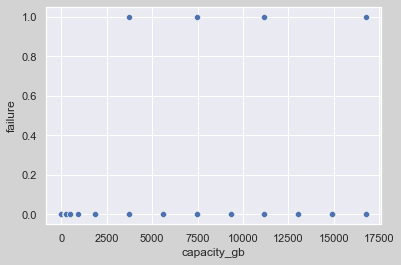

In [10]:
sns.set(rc={'figure.facecolor': "lightgray"})
ax = sns.scatterplot(data=df, x="capacity_gb", y="failure")

In [11]:
df.query("failure==1")

,date,serial_number,model,capacity_bytes,failure,capacity_gb
11388,2021-01-15,ZLW0GGTP,ST12000NM001G,12000138625024,1,11176.000000
30706,2021-01-15,S300Z7MC,ST4000DM000,4000787030016,1,3726.023277
105299,2021-01-15,ZA1261TF,ST8000DM002,8001563222016,1,7452.036461
131001,2021-01-15,ZR501221,ST18000NM000J,18000207937536,1,16764.000000
144717,2021-01-15,ZLW0C6YV,ST12000NM001G,12000138625024,1,11176.000000


In [12]:
# setup for reading time series
#serials = ['ZLW0EGC6', 'Z305B2QN', 'ZLW0C6NE', 'ZJV0XJQ3', 'ZLW18MKT', 'ZLW0GGTP']
serials = ['ZLW0EGC6', 'ZLW0GGTP']
start_date = "2021-01-11"
end_date = "2021-01-16"
days = pd.Period(end_date).dayofyear - pd.Period(start_date).dayofyear + 1
column_to_save = ['date', 'serial_number', 'model', 'capacity_bytes', 'failure', 'smart_1_normalized']
#column_to_save = ['date', 'capacity_bytes', 'failure', 'smart_1_normalized']
#column_to_save = column_name_all

# Prepare the DataFrame for Time Series

In [13]:
# create a list of empty dataframes for concatenation later
time_series_dataset = []
for serial in serials:
    time_series_dataset.append(pd.DataFrame([], columns=column_to_save))

memory_used = 0
memory_warning_displayed = False
print(f"Read files for building time series from {start_date} to {end_date}; totally {days} days; {len(serials)} serials")
for day in range(days):
    date = pd.Period(start_date) + day
    print(f"  reading data for the date {date}; progress: {day+1}/{days}")
    file_path = "data_Q1_2021/" + str(date) + ".csv"
    df_tmp = pd.read_csv(file_path, parse_dates=["date"])
    for i, serial in enumerate(serials):
        df_tmp_serial = df_tmp.query("serial_number == @serial")[column_to_save]
        time_series_dataset[i] = pd.concat([time_series_dataset[i], df_tmp_serial], ignore_index=True)
        memory_used += time_series_dataset[i].memory_usage(deep=True).sum()
    if memory_used/1024**3 > 1 and not memory_warning_displayed:
        print(" ### Warning: memory used for time-series dataframe > 1 GB ###")
        memory_warning_displayed = True

print("Time series was read successfully")
print(f"Memory used for dataframe: {(memory_used/1024**3).round(3)} GB")

Read files for building time series from 2021-01-11 to 2021-01-16; totally 6 days; 2 serials
  reading data for the date 2021-01-11; progress: 1/6
  reading data for the date 2021-01-12; progress: 2/6
  reading data for the date 2021-01-13; progress: 3/6
  reading data for the date 2021-01-14; progress: 4/6
  reading data for the date 2021-01-15; progress: 5/6
  reading data for the date 2021-01-16; progress: 6/6
Time series was read successfully
Memory used for dataframe: 0.0 GB


In [14]:
# check the dataframe of a HDD specified by choice
choice = 1
time_series_dataset[choice].head(5)

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized
0,2021-01-11,ZLW0GGTP,ST12000NM001G,12000138625024,0,83.0
1,2021-01-12,ZLW0GGTP,ST12000NM001G,12000138625024,0,83.0
2,2021-01-13,ZLW0GGTP,ST12000NM001G,12000138625024,0,100.0
3,2021-01-14,ZLW0GGTP,ST12000NM001G,12000138625024,0,84.0
4,2021-01-15,ZLW0GGTP,ST12000NM001G,12000138625024,1,81.0


In [15]:
time_series_dataset[choice].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                5 non-null      datetime64[ns]
 1   serial_number       5 non-null      object        
 2   model               5 non-null      object        
 3   capacity_bytes      5 non-null      object        
 4   failure             5 non-null      object        
 5   smart_1_normalized  5 non-null      float64       
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 368.0+ bytes


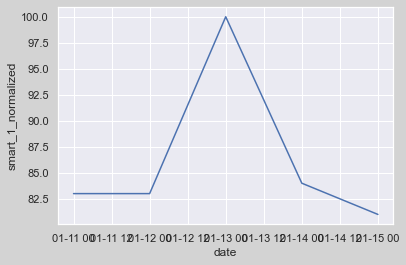

In [16]:
sns.set(rc={'figure.facecolor': "lightgray"})
ax = sns.lineplot(data=time_series_dataset[choice], x="date", y="smart_1_normalized")

In [17]:
print("Save read time series to csv files")
for i, serial in enumerate(serials):
    file_path = "time_series/" + serial + "_" + start_date + "_to_" + end_date + ".csv" 
    time_series_dataset[i].to_csv(file_path)
    print(f"  save to \"{file_path}\"; progress {i}/{len(serials)}")
print("Time series are saved successfully")

Save read time series to csv files
  save to "time_series/ZLW0EGC6_2021-01-11_to_2021-01-16.csv"; progress 0/2
  save to "time_series/ZLW0GGTP_2021-01-11_to_2021-01-16.csv"; progress 1/2
Time series are saved successfully


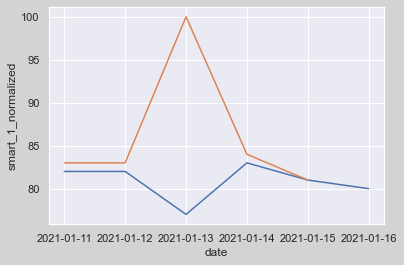

In [18]:
sns.set(rc={'figure.facecolor': "lightgray"})
for i, serial in enumerate(serials):
    ax = sns.lineplot(data=time_series_dataset[i], x="date", y="smart_1_normalized")